# Training an $E(3)$-equivariant GNN on QM9.
this is probably the wrong title because the dataset appears naturally $E(3)$-invariant. I think the point here is to construct a message-passing neural net, not an equivariant one.

In [2]:
import torch_geometric as tg
import torch
import numpy as np
import pandas as pd

/var/folders/1m/gvn54nz553d8jxtvjvrv56kh0000gn/T/ipykernel_7733/1484302939.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [141]:
# make arrays to keep track of where new molecules begin in the dataset
graph_indicator = open('baby_QM9/raw/graph_indicator.txt').read().splitlines()
# the first index obviously begins a new molecule
new_graph_node_indices = [0]
# if the value in the graph_indicator array is not identical to the previous value, then a new molecule begins in this position
for i in range(1,len(graph_indicator)):
    if graph_indicator[i] != graph_indicator[i-1]:
        new_graph_node_indices.append(int(i))
# the last molecule ends at the last index
new_graph_node_indices.append(len(graph_indicator))

In [142]:
# load adjacency_list into Torch tensor
adjacency_list_df = pd.read_csv("baby_QM9/raw/adjacency_list.txt", header=None)
adjacency_list = torch.tensor(adjacency_list_df.values)

In [143]:
# create a list of the nodes from which each edge begins, subtracting 1 from each item because the list has the first node as #1, but 0-indexing is easier here
origin_node_list = [i[0].item()-1 for i in adjacency_list]

In [144]:
# create an empty array of the indices in edge files at which each new graph begins
new_graph_edge_indices = []
# for each index at which a new graph begins in the node list, we search through the adjacency list, find the first an edge that leaves from the node with the corresponding index, and flag it as the beginning of a new graph in the edge list
for index in new_graph_node_indices[:-1]:
    new_graph_edge_indices.append(origin_node_list.index(index))
# the last molecule ends at the last index
new_graph_edge_indices.append(len(origin_node_list))

In [145]:
# now we can load the rest of the txt files into torch tensors
# load node_attributes into Torch tensor
node_attributes_df = pd.read_csv("baby_QM9/raw/node_attributes.txt", header=None)
node_attributes = torch.tensor(node_attributes_df.values)

# load edge_attributes into Torch tensor
edge_attributes_df = pd.read_csv("baby_QM9/raw/edge_attributes.txt", header=None)
edge_attributes = torch.tensor(edge_attributes_df.values)

# load Y into Torch tensor
Y_df = pd.read_csv("baby_QM9/raw/Y.txt", header=None)
Y = torch.tensor(Y_df.values)

In [146]:
import os.path as osp
from torch_geometric.data import Dataset, download_url

class MoleculeDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)

    @property
    def raw_file_names(self):
        return ['adjacency_list.txt', 'edge_attributes.txt', 'graph_indicator.txt', 'node_attributes.txt', 'Y.txt']

    @property
    def processed_file_names(self):
        return 'not_implemented.pt'

    def download(self):
        pass

    def process(self):
        # for every range indicated by new_graph_node_indices and new_graph_edge_indices (which are equal in length to each other)
        for (a,b) in zip(range(len(new_graph_edge_indices)), range(len(new_graph_edge_indices))[1:]):
            # grab the part of node_attributes corresponding to the current molecule
            n_a = node_attributes[new_graph_node_indices[a]:new_graph_node_indices[b]]
            # grab the part of edge_attributes corresponding to the current molecule
            e_a = edge_attributes[new_graph_edge_indices[a]:new_graph_edge_indices[b]]
            # grab the part of adjacency_list corresponding to the current molecule, but make a new object in memory because we have to reindex the items
            a_l = adjacency_list[new_graph_edge_indices[a]:new_graph_edge_indices[b]].detach().clone()
            # find the number of the first node in this molecule's adjacency list
            node_0_value = a_l[0][0].item()
            # subtract that from the each of the node numbers in this molecule's adjacency list, so that instead of connections between atoms (n,n+m), we have connections between atoms (0,m) for ease of use
            for i in range(len(a_l)):
                for j in range(len(a_l[i])):
                    a_l[i][j] -= node_0_value
            # flip it on its side to fit PyTorch_Geometric's demands for the dimensions of this tensor
            a_l = torch.transpose(a_l, 0, 1)
            # the ground-truth for this molecule, which is the a-th on our list, is just Y[a]
            y = Y[a]
            
            # create Data object
            data = Data(x=n_a, edge_index=a_l, edge_attr=e_a, y=y)
            
            torch.save(data, os.path.join(self.processed_dir, f'data_{a}.pt'))

    def len(self):
        return len(self.processed_file_names)

    def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, f'data_{idx}.pt'))
        return data

In [147]:
from torch_geometric.data import Data
molecules = []

# for every range indicated by new_graph_node_indices and new_graph_edge_indices (which are equal in length to each other)
for (a,b) in zip(range(len(new_graph_node_indices)), range(len(new_graph_node_indices))[1:]):
    # grab the part of node_attributes corresponding to the current molecule
    n_a = node_attributes[new_graph_node_indices[a]:new_graph_node_indices[b]]
    # grab the part of edge_attributes corresponding to the current molecule
    e_a = edge_attributes[new_graph_edge_indices[a]:new_graph_edge_indices[b]]
    # grab the part of adjacency_list corresponding to the current molecule, but make a new object in memory because we have to reindex the items
    a_l = adjacency_list[new_graph_edge_indices[a]:new_graph_edge_indices[b]].detach().clone()
    # find the number of the first node in this molecule's adjacency list
    node_0_value = a_l[0][0].item()
    # subtract that from the each of the node numbers in this molecule's adjacency list, so that instead of connections between atoms (n,n+m), we have connections between atoms (0,m) for ease of use
    for i in range(len(a_l)):
        for j in range(len(a_l[i])):
            a_l[i][j] -= node_0_value
    # flip it on its side to fit PyTorch_Geometric's demands for the dimensions of this tensor
    a_l = torch.transpose(a_l, 0, 1)
    # the ground-truth for this molecule, which is the a-th on our list, is just Y[a]
    y = Y[a]
    # add to our array of molecules
    molecules.append(Data(x=n_a, edge_index=a_l, edge_attr=e_a, y=y))

6000001
6000001
6000001
1000000
1000000
1000000
1000000
1000000
1000000
------------------------------
[1, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
[1, 0, 0, 0]
------------------------------
[0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 4, 5, 6, 7, 8]
[1, 2, 3, 4, 0, 2, 5, 6, 0, 1, 7, 8, 0, 0, 1, 1, 2, 2]


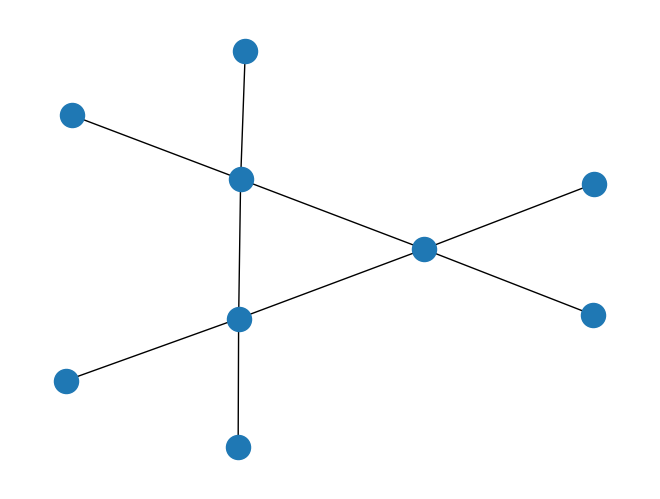

In [250]:
import matplotlib.pyplot as plt
import networkx as nx
i = 15
nx.draw(tg.utils.to_networkx(molecules[i], to_undirected=True))
for atom in molecules[i]['x']:
    s=''
    for j in atom[5:12]:
        s += str(int(j.item()))
    print(f'{s}')
print('-'*30)
for k in molecules[i]['edge_attr']:
    print(k.tolist())
print('-'*30)
for k in molecules[i]['edge_index'].tolist():
    print(k)